<header style="background-color: #ffe3f7; padding: 10px;">
    <h1 style="text-align: center; font-family: Segoe UI; font-size: 36px; color: #222;"><b>Kidney Stone Prediction</b></h1>
</header>

> **Playground Series - Season 3, Episode 12**

The dataset for this competition (both train and test) was generated from a deep learning model trained on the [Kidney Stone Prediction based on Urine Analysis](https://www.kaggle.com/datasets/vuppalaadithyasairam/kidney-stone-prediction-based-on-urine-analysis) dataset. Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance.

> **Features**

- `id`: Observation ID
- `ph`: PH of urine
- `osmo`: Osmolarity of urine
- `cond`: Conductivity of urine
- `urea`: Concentration of urea in urine
- `calc`: Concentration of calcium in urine
- `target`: 0 - Absence of stone; 1 - Presence of stone

> **Table of Contents**

- [Libraries](#Libraries)
- [Exploring the Dataset](#Importing-the-Dataset)
- [Feature Engineering](#Feature-Engineering)
    - [Combining Features](#Combining-Features)
    - [Cluster Analysis](#Cluster-Analysis)
    - [Preparing the Data](#Preparing-the-Data)
- [Fitting the Data](#Fitting-the-Data)
    - [Stochastic Gradient Descent](#Stochastic-Gradient-Descent)
    - [CatBoost Classifier](#CatBoost-Classifier)
    - [Logistic Regression](#Logistic-Regression)
    - [Support Vector Machines](#Support-Vector-Machines)
    - [Decision Tree](#Decision-Tree)
    - [Random Forest](#Random-Forest)
    - [XGBoost Classifier](#XGBoost-Classifier)
    - [MLP Classifier](#MLP-Classifier)
    - [Naive Bayes](#Naive-Bayes)
    - [KNeighbors Classifier](#KNeighbors-Classifier)
    - [AdaBoost](#AdaBoost)
- [Model Score](#Model-Scores)
- [Predicting Kidney Stone](#Predicting-Kidney-Stone)
___

<br><br>

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = '2'

In [231]:
def plot_precision_recall_vs_threshold(axis, precisions, recalls, thresholds):
    axis.plot(thresholds, precisions[:-1], "b--", label="Precision")
    axis.plot(thresholds, recalls[:-1], "g-", label="Recall")
    axis.legend(["Precision", "Recall"])
    axis.set_title("Precision/Recall vs. Thresholds")
    axis.set_xlabel("Thresholds")

def plot_roc_curve(axis, fpr, tpr, label=None):
    axis.plot(fpr, tpr, linewidth=2, label=label)
    axis.plot([0,1], [0,1], "k--")
    axis.grid(True)
    axis.set_title("ROC Curve")
    axis.set_xlabel("FPR")
    axis.set_ylabel("TPR")

## Libraries

In [193]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier

## Exploring the Dataset

In [4]:
# Importing the data
data = pd.read_csv("./data/playground-series-s3e12/train.csv")

In [5]:
# Looking at first 5 obs
data.head()

,id,gravity,ph,osmo,cond,urea,calc,target
0,0,1.013,6.19,443,14.8,124,1.45,0
1,1,1.025,5.40,703,23.6,394,4.18,0
2,2,1.009,6.13,371,24.5,159,9.04,0
3,3,1.021,4.91,442,20.8,398,6.63,1
4,4,1.021,5.53,874,17.8,385,2.21,1


In [6]:
# Printing out the dataset shape
print(f"The shape of the dataset is {data.shape}.")

The shape of the dataset is (414, 8).


In [7]:
# Dropping the id col, as it's not relevant
data.drop(["id"], axis=1, inplace=True)

In [8]:
# Getting the dataset info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   gravity  414 non-null    float64
 1   ph       414 non-null    float64
 2   osmo     414 non-null    int64  
 3   cond     414 non-null    float64
 4   urea     414 non-null    int64  
 5   calc     414 non-null    float64
 6   target   414 non-null    int64  
dtypes: float64(4), int64(3)
memory usage: 22.8 KB


In [9]:
# Summary statistics
data.describe().T

,count,mean,std,min,25%,50%,75%,max
gravity,414.0,1.017894,0.006675,1.005,1.012,1.018,1.022,1.04
ph,414.0,5.955459,0.642260,4.760,5.530,5.740,6.280,7.94
osmo,414.0,651.545894,234.676567,187.000,455.250,679.500,840.000,1236.00
cond,414.0,21.437923,7.514750,5.100,15.500,22.200,27.600,38.00
urea,414.0,278.657005,136.442249,10.000,170.000,277.000,385.000,620.00
calc,414.0,4.114638,3.217641,0.170,1.450,3.130,6.630,14.34
target,414.0,0.444444,0.497505,0.000,0.000,0.000,1.000,1.00


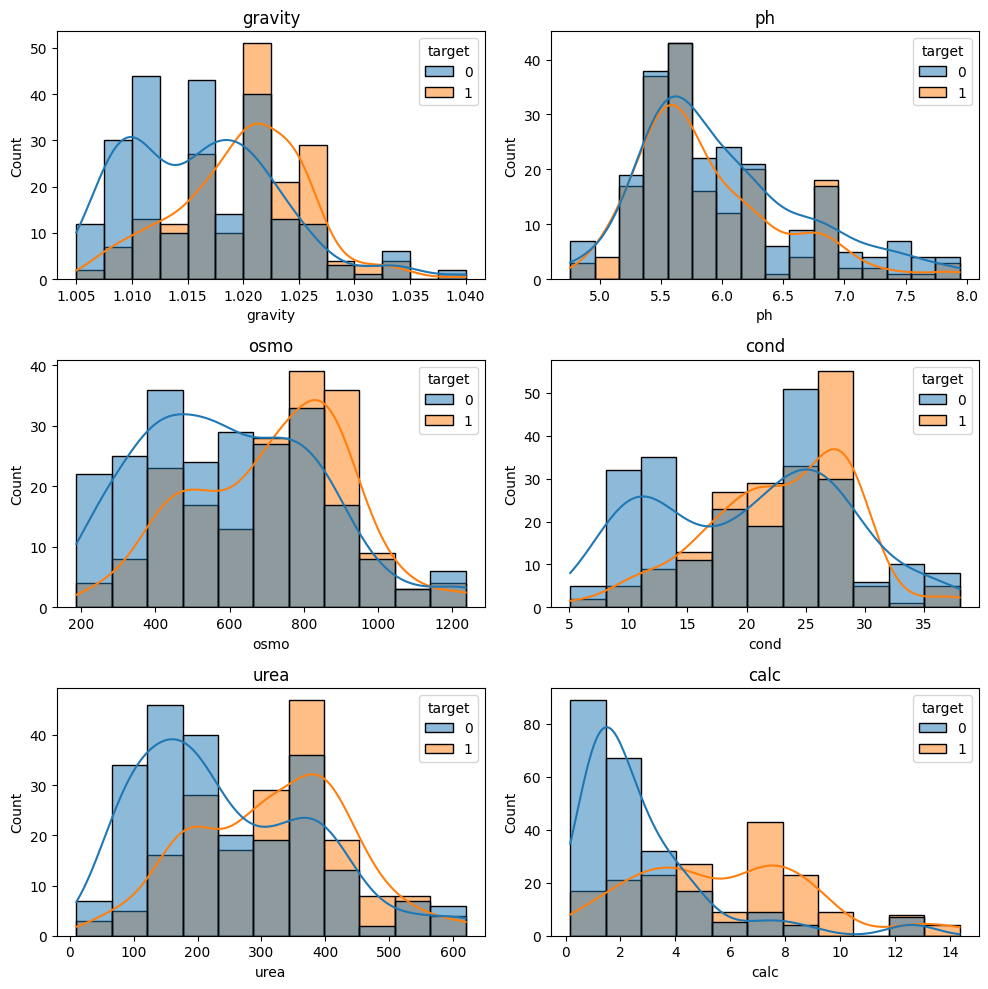

In [10]:
# Plotting histograms
def plot_histograms(data, columns, hue, nrows, ncols):
    # Create a grid of subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))

    # Flatten the axes array to simplify indexing
    axes = axes.flatten()

    # Plot a histogram of each column on a separate subplot
    for i, column in enumerate(columns):
        sns.histplot(data=data, x=column, hue=hue, ax=axes[i], kde=True)
        axes[i].set_title(column)

    # Remove any unused subplots
    for i in range(len(columns), len(axes)):
        fig.delaxes(axes[i])

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()
    
plot_histograms(data, ["gravity", "ph", "osmo", "cond", "urea", "calc"], "target", 3, 2)

We can not that `ph` has a similar distribution for both individuals with and without the stone. For the rest, lower numbers are associated with the absence (`target` = 0) of the stone.

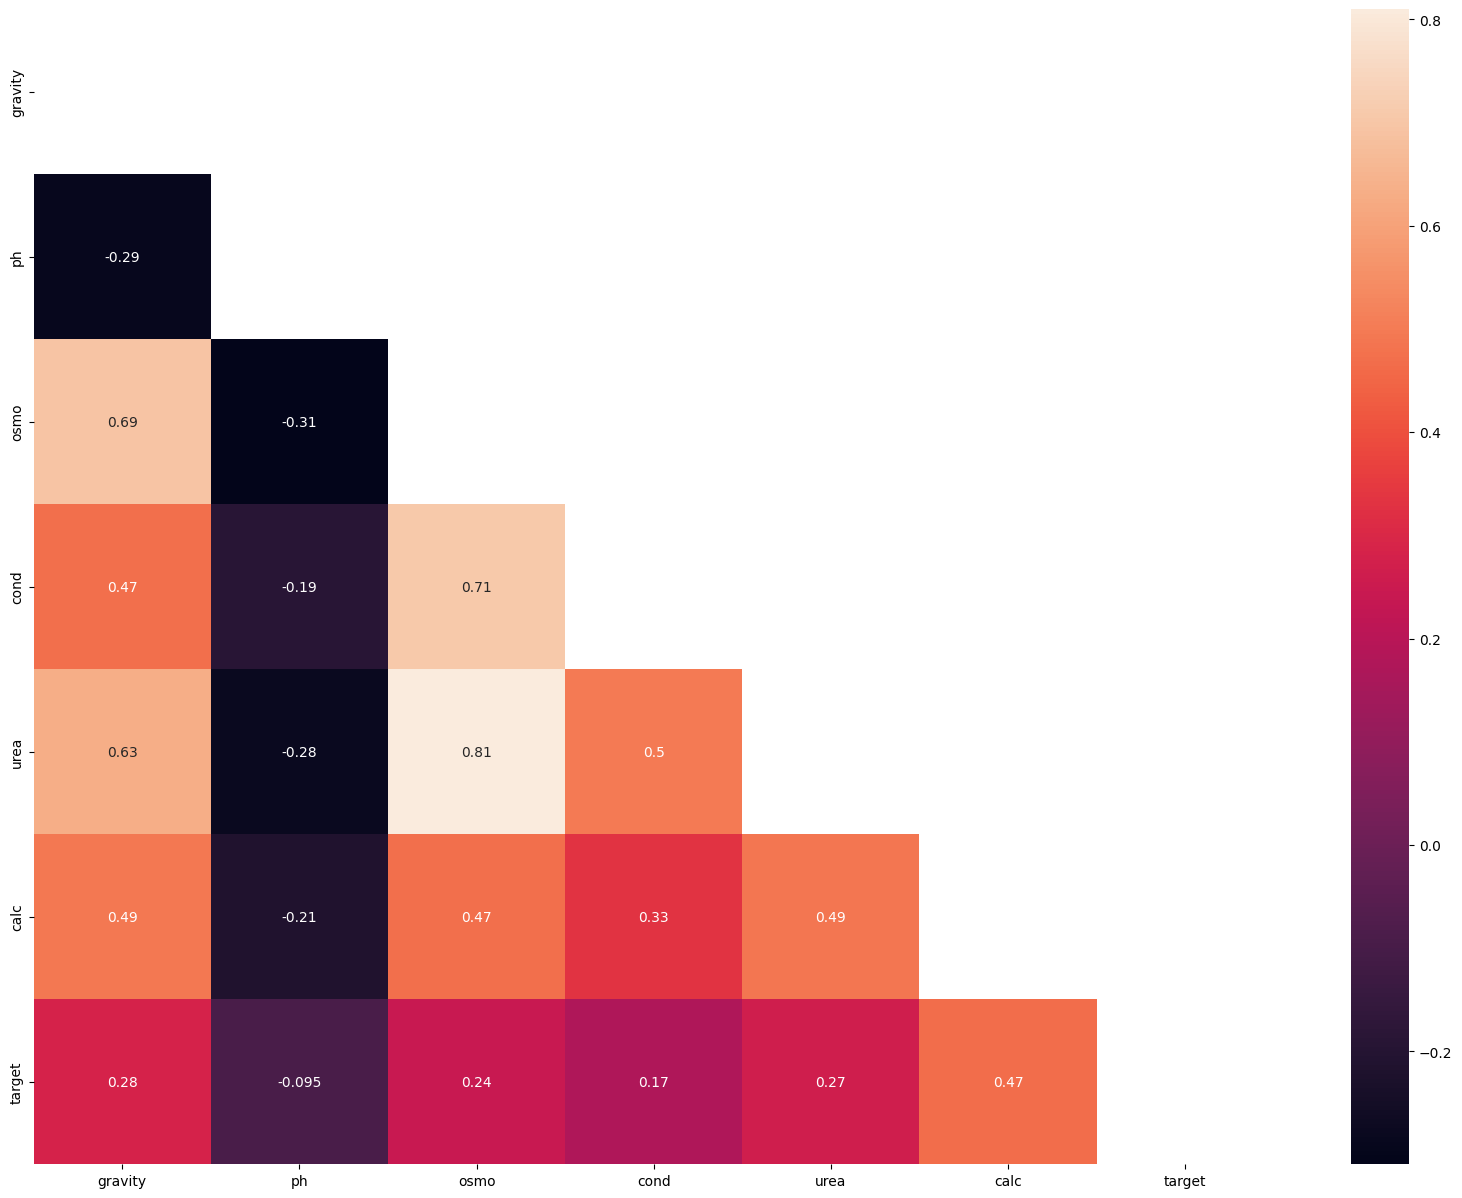

In [11]:
# Plotting the correlations
pearson = data.corr()

plt.figure(figsize=(20,15))
sns.heatmap(pearson, annot=True, mask=np.triu(pearson))
plt.show()

As we would expect, `ph` has the lowest correlation to `target`. `calc` is the variable most correlated to `target`.

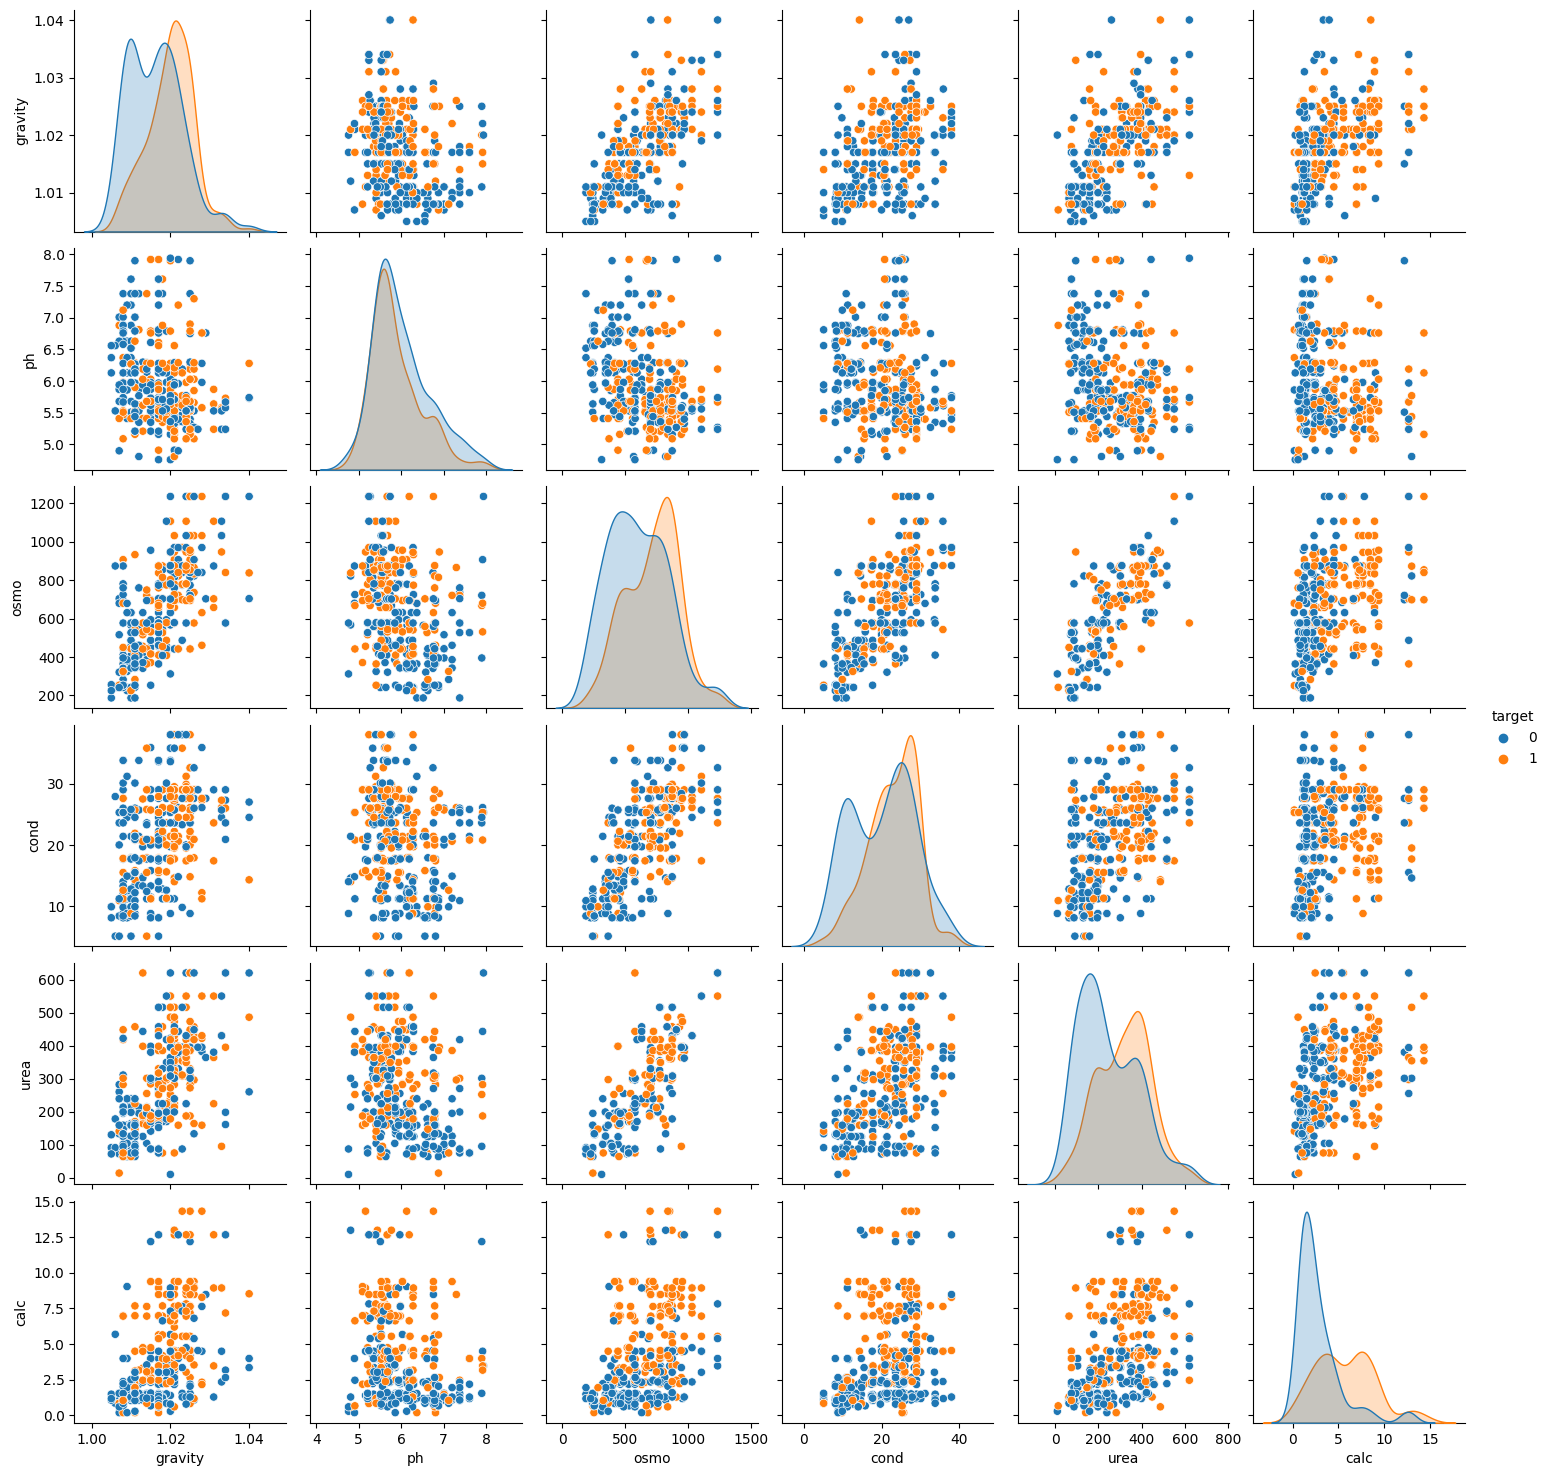

In [12]:
sns.pairplot(data=data, hue="target",
             vars=["gravity", "ph", "osmo", "cond", "urea", "calc"])
plt.show()

## Feature Engineering

### Combining Features

Let's try creating some new features. I'm not a biologist, so I don't know what would make sense here (or better yet, if it would make sense to combine the features). But we've seen that `ph` is not the best variable to predict the target. So let's combine it with some of the other features.

In [29]:
# Create a copy of the dataset
data_copy = data.copy()

In [14]:
for i in ["gravity", "osmo", "cond", "urea", "calc"]:
    print(f"ph / {i}:")
    data_copy["placeholder"] = data_copy["ph"] / data_copy[i]
    display(data_copy[["placeholder", "target"]].corr())

ph / gravity:


,placeholder,target
placeholder,1.000000,-0.110475
target,-0.110475,1.000000


ph / osmo:


,placeholder,target
placeholder,1.000000,-0.252036
target,-0.252036,1.000000


ph / cond:


,placeholder,target
placeholder,1.000000,-0.217256
target,-0.217256,1.000000


ph / urea:


,placeholder,target
placeholder,1.000000,-0.150496
target,-0.150496,1.000000


ph / calc:


,placeholder,target
placeholder,1.000000,-0.185012
target,-0.185012,1.000000


Let's select some of them to include in our dataset:

In [ ]:
# Delete the temporary variable
data_copy.drop(["placeholder"], axis=1, inplace=True)

In [30]:
# Adding the new features
data_copy["ph_osmo"] = data_copy["ph"] / data_copy["osmo"]
data_copy["ph_cond"] = data_copy["ph"] / data_copy["cond"]
data_copy["ph_calc"] = data_copy["ph"] / data_copy["calc"]

In [31]:
data_copy.head()

,gravity,ph,osmo,cond,urea,calc,target,ph_osmo,ph_cond,ph_calc
0,1.013,6.19,443,14.8,124,1.45,0,0.013973,0.418243,4.268966
1,1.025,5.40,703,23.6,394,4.18,0,0.007681,0.228814,1.291866
2,1.009,6.13,371,24.5,159,9.04,0,0.016523,0.250204,0.678097
3,1.021,4.91,442,20.8,398,6.63,1,0.011109,0.236058,0.740573
4,1.021,5.53,874,17.8,385,2.21,1,0.006327,0.310674,2.502262


### Cluster Analysis

Since we don't have many features, what about we try to create a cluster analysis?

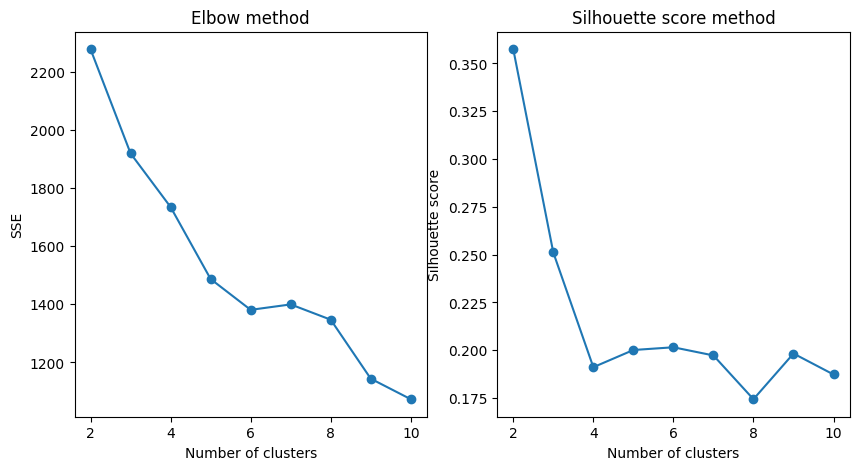

In [17]:
# Select the columns you want to cluster on
X = data_copy.drop(["target"], axis=1)

# Standardize the data (optional but recommended for KMeans)
X = (X - X.mean()) / X.std()

# Determine the optimal number of clusters using the Elbow method
sse = []
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, n_init="auto")
    kmeans.fit(X)
    sse.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))
    
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(range(2, 11), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow method')

plt.subplot(1,2,2)
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette score method')

plt.show()

In [32]:
# Choose the optimal number of clusters based on the Elbow method
optimal_k = 3  # change this to the elbow point you see in the plot

# Perform KMeans clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, n_init="auto")
kmeans.fit(X)

# Add the cluster labels to your DataFrame
data_copy['cluster'] = kmeans.labels_

# Print the results
data_copy.head()

,gravity,ph,osmo,cond,urea,calc,target,ph_osmo,ph_cond,ph_calc,cluster
0,1.013,6.19,443,14.8,124,1.45,0,0.013973,0.418243,4.268966,2
1,1.025,5.40,703,23.6,394,4.18,0,0.007681,0.228814,1.291866,0
2,1.009,6.13,371,24.5,159,9.04,0,0.016523,0.250204,0.678097,2
3,1.021,4.91,442,20.8,398,6.63,1,0.011109,0.236058,0.740573,0
4,1.021,5.53,874,17.8,385,2.21,1,0.006327,0.310674,2.502262,1


### Preparing the Data

In [39]:
train_targets = data_copy["target"]
data_copy.drop(["target"], axis=1, inplace=True)

In [238]:
data_copy

,gravity,ph,osmo,cond,urea,calc,ph_osmo,ph_cond,ph_calc,cluster
0,1.013,6.19,443,14.8,124,1.45,0.013973,0.418243,4.268966,2
1,1.025,5.40,703,23.6,394,4.18,0.007681,0.228814,1.291866,0
2,1.009,6.13,371,24.5,159,9.04,0.016523,0.250204,0.678097,2
3,1.021,4.91,442,20.8,398,6.63,0.011109,0.236058,0.740573,0
4,1.021,5.53,874,17.8,385,2.21,0.006327,0.310674,2.502262,1
...,...,...,...,...,...,...,...,...,...,...
409,1.011,5.21,527,21.4,75,1.53,0.009886,0.243458,3.405229,2
410,1.024,5.53,577,19.7,224,0.77,0.009584,0.280711,7.181818,0
411,1.018,6.28,455,22.2,270,7.68,0.013802,0.282883,0.817708,2
412,1.008,7.12,325,12.6,75,1.03,0.021908,0.565079,6.912621,2


In [250]:
num_attribs = list(data_copy.columns)[0:-1]
cat_attribs = ["cluster"]

pipeline = ColumnTransformer([
        ("num", StandardScaler(), num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

In [251]:
data_prepared = pipeline.fit_transform(data_copy)

In [252]:
data_prepared

array([[-0.73403157,  0.36562268, -0.8897276 , ...,  0.        ,
         0.        ,  1.        ],
       [ 1.06590369, -0.86589692,  0.21952069, ...,  1.        ,
         0.        ,  0.        ],
       [-1.33400999,  0.27208954, -1.19690404, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 0.01594146,  0.50592238, -0.83853152, ...,  0.        ,
         0.        ,  1.        ],
       [-1.48400459,  1.81538625, -1.39315566, ...,  0.        ,
         0.        ,  1.        ],
       [-1.03402078,  0.27208954, -1.22676842, ...,  0.        ,
         0.        ,  1.        ]])

In [253]:
X, y = data_prepared, train_targets

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

While we're at it, let's prepare also the final test data:

In [254]:
test_data = pd.read_csv("./data/playground-series-s3e12/test.csv")

In [255]:
test_data["ph_osmo"] = test_data["ph"] / test_data["osmo"]
test_data["ph_cond"] = test_data["ph"] / test_data["cond"]
test_data["ph_calc"] = test_data["ph"] / test_data["calc"]

In [256]:
kmeans.fit(test_data)
test_data['cluster'] = kmeans.labels_

In [257]:
test_ids = test_data["id"]
test_data.drop(["id"], axis=1, inplace=True)

In [258]:
test_prepared = pipeline.fit_transform(test_data)

In [259]:
test_prepared

array([[-0.20280456, -1.15389851, -1.31346969, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.25474905, -0.42787688,  0.92868895, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.86482054, -0.95589261,  0.18271557, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 1.93244564, -0.42787688,  0.92868895, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.10223118, -0.7743872 , -0.47424963, ...,  0.        ,
         1.        ,  0.        ],
       [-0.20280456,  0.41364819,  0.18271557, ...,  1.        ,
         0.        ,  0.        ]])

## Fitting the Data

In [179]:
class ModelDiagnostics:
    def __init__(self, model, X_train, X_test, y_train, y_test):
        self.model = model
        self.X_train = X_train
        self.y_train = y_train
        
    def trainModel(self):
        self.model.fit(self.X_train, self.y_train)
        cv_scores = cross_val_score(self.model, self.X_train, self.y_train, cv=5, scoring="accuracy")
        y_train_pred = cross_val_predict(self.model, self.X_train, self.y_train, cv=5)
        
        print(f"5-fold CV Scores Mean: {cv_scores.mean()}.")
        print(f"Precision: {precision_score(y_train, y_train_pred)}.")
        print(f"Recall: {recall_score(y_train, y_train_pred)}.")
        print(f"F1 Score: {f1_score(y_train, y_train_pred)}.")
        
        return 
    
    def testModel(self):
        y_pred = self.model.predict(X_test)
        
        print(f"Accuracy: {accuracy_score(y_test, y_pred)}.")
        print(f"Precision: {precision_score(y_test, y_pred)}.")
        print(f"Recall: {recall_score(y_test, y_pred)}.")
        print(f"F1 Score: {f1_score(y_test, y_pred)}.")
        
        return
        
    
    def trainconfusionMatrix(self):
        ConfusionMatrixDisplay(confusion_matrix(y_train, y_train_pred, labels=np.array([0, 1])),
                       display_labels=np.array([0, 1])).plot(cmap='Blues')
        plt.title("Confusion Matrix - Training Set")
        plt.show()
        
        return
    
    def testconfusionMatrix(self):
        ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, labels=sgd.classes_),
                       display_labels=sgd.classes_).plot(cmap='Purples')
        plt.title("Confusion Matrix - Test Set")
        plt.show()
        
        return
    
    def trainPR_ROC(self):
        precisions, recalls, thresholds_pr = precision_recall_curve(y_train, y_train_pred)
        fpr, tpr, thresholds_roc = roc_curve(y_train, y_train_pred)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

        plot_precision_recall_vs_threshold(ax1, precisions, recalls, thresholds_pr)
        plot_roc_curve(ax2, fpr, tpr)

        plt.show()
        
        print(f"AUC: {roc_auc_score(y_train, y_train_pred)}.")
        
        return fpr, tpr
    
    def testPR_ROC(self):
        precisions, recalls, thresholds_pr = precision_recall_curve(y_test, y_pred)
        fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

        plot_precision_recall_vs_threshold(ax1, precisions, recalls, thresholds_pr)
        plot_roc_curve(ax2, fpr, tpr)

        plt.show()
        
        print(f"AUC: {roc_auc_score(y_test, y_pred)}.")
        
        return

## SGD

In [183]:
params = {'alpha': 0.01, 'eta0': 0.1, 'learning_rate': 'optimal', 'loss': 'modified_huber', 'max_iter': 1000, 'penalty': 'l1'}
sgd = SGDClassifier(**params)
StochasticGD = ModelDiagnostics(sgd, X_train, X_test, y_train, y_test)

#### Training Set

In [184]:
StochasticGD.trainModel()

5-fold CV Scores Mean: 0.6735866123925824.
Precision: 0.631578947368421.
Recall: 0.5753424657534246.
F1 Score: 0.6021505376344086.


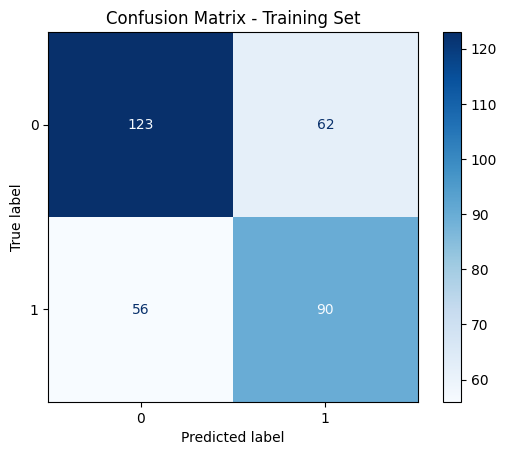

In [185]:
StochasticGD.trainconfusionMatrix()

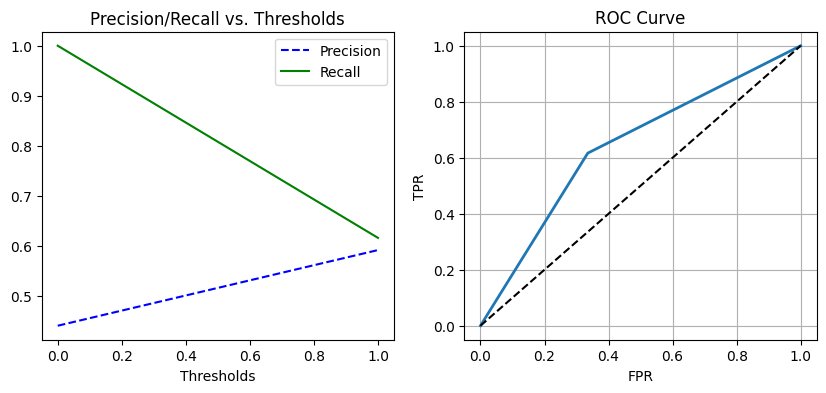

AUC: 0.6406516105146242.


In [186]:
fpr_sgd, tpr_sgd = StochasticGD.trainPR_ROC()

#### Test Set

In [187]:
StochasticGD.testModel()

Accuracy: 0.7831325301204819.
Precision: 0.7380952380952381.
Recall: 0.8157894736842105.
F1 Score: 0.775.


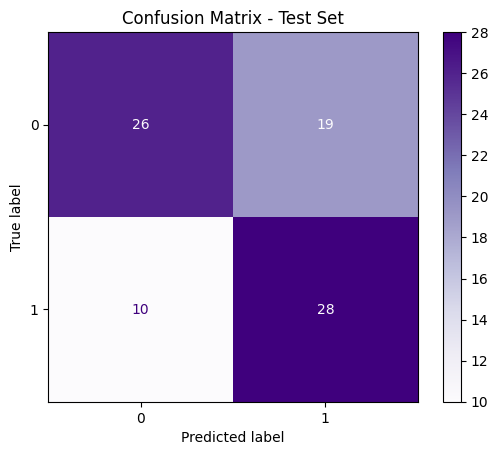

In [188]:
StochasticGD.testconfusionMatrix()

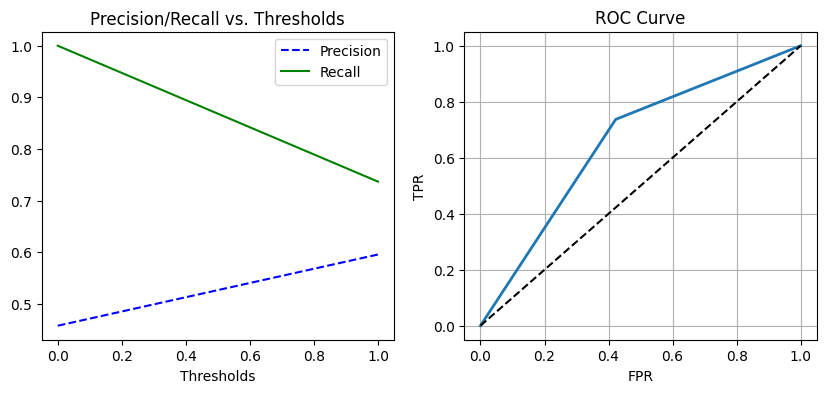

AUC: 0.6573099415204678.


In [189]:
StochasticGD.testPR_ROC()

## AdaBoost

In [197]:
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.1, 1],
    'algorithm': ['SAMME', 'SAMME.R']
}

In [198]:
ada = AdaBoostClassifier()

In [199]:
# Create a GridSearchCV object and fit it to the data
grid_search = GridSearchCV(ada, param_grid, cv=5, scoring='accuracy')

In [200]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=AdaBoostClassifier(),
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'learning_rate': [0.01, 0.1, 1],
                         'n_estimators': [50, 100, 150, 200]},
             scoring='accuracy')

In [201]:
# Print the best hyperparameters and their corresponding score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best hyperparameters:  {'algorithm': 'SAMME.R', 'learning_rate': 0.01, 'n_estimators': 150}
Best score:  0.736951605608322


In [202]:
params = {'algorithm': 'SAMME.R', 'learning_rate': 0.01, 'n_estimators': 150}

In [203]:
ada_ = AdaBoostClassifier(**params)
AdaBoost = ModelDiagnostics(ada_, X_train, X_test, y_train, y_test)

#### Training Set

In [204]:
AdaBoost.trainModel()

5-fold CV Scores Mean: 0.736951605608322.
Precision: 0.7286821705426356.
Recall: 0.6438356164383562.
F1 Score: 0.6836363636363637.


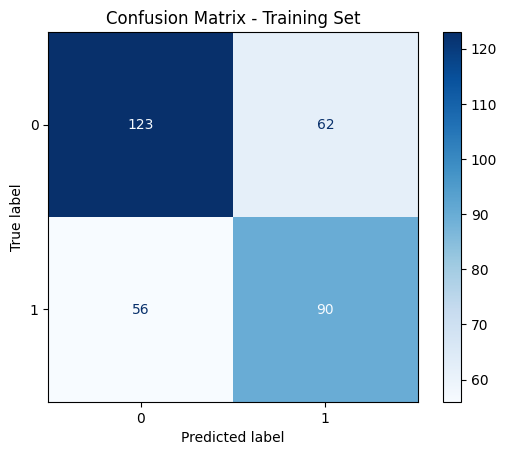

In [205]:
AdaBoost.trainconfusionMatrix()

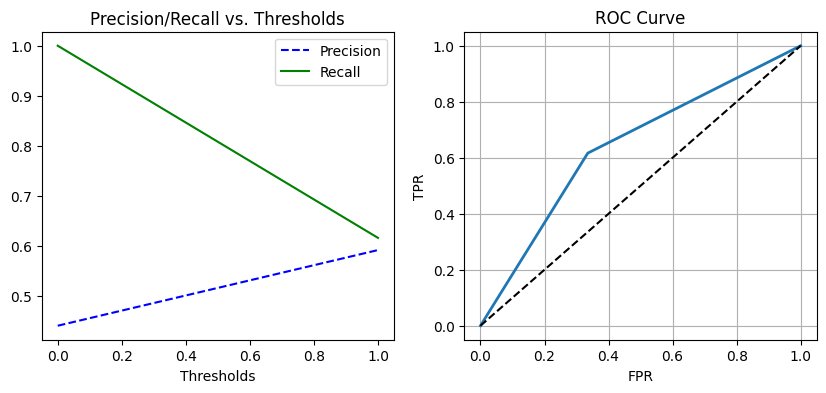

AUC: 0.6406516105146242.


In [207]:
fpr_ada, tpr_ada = AdaBoost.trainPR_ROC()

#### Test Set

In [208]:
AdaBoost.testModel()

Accuracy: 0.7951807228915663.
Precision: 0.7837837837837838.
Recall: 0.7631578947368421.
F1 Score: 0.7733333333333334.


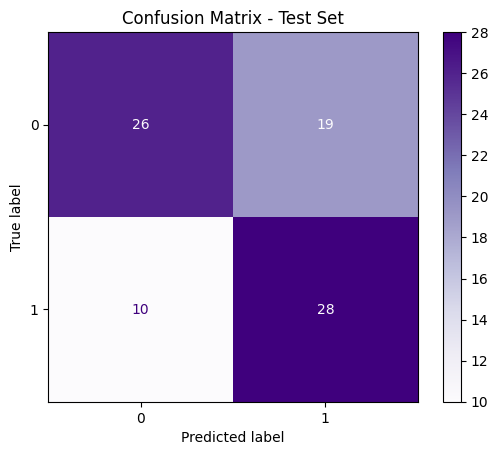

In [209]:
AdaBoost.testconfusionMatrix()

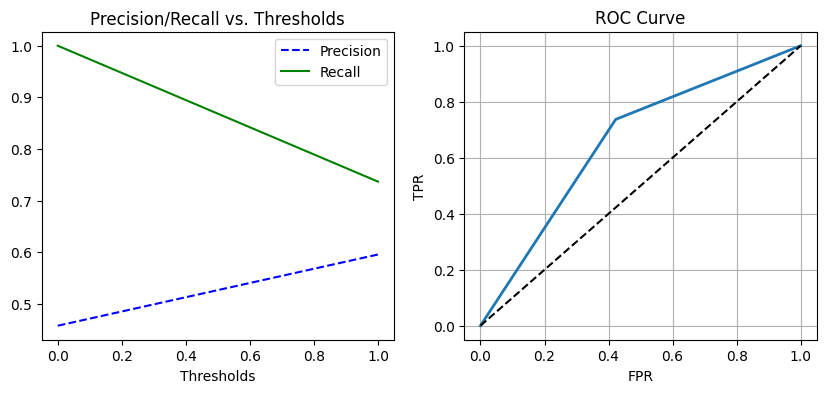

AUC: 0.6573099415204678.


In [210]:
AdaBoost.testPR_ROC()

## KNN

In [219]:
param_grid = {'n_neighbors': [3, 5, 7, 9, 11],
              'weights': ['uniform', 'distance'],
              'p': [1, 2]}

knn_ = KNeighborsClassifier()

In [220]:
grid_search = GridSearchCV(knn_, param_grid, cv=5)

In [221]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7, 9, 11], 'p': [1, 2],
                         'weights': ['uniform', 'distance']})

In [222]:
# Print the best hyperparameters and their corresponding score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best hyperparameters:  {'n_neighbors': 11, 'p': 2, 'weights': 'distance'}
Best score:  0.6069199457259158


In [223]:
params = {'n_neighbors': 11, 'p': 2, 'weights': 'distance'}

In [224]:
knn = KNeighborsClassifier(**params)
KNeighbors = ModelDiagnostics(knn, X_train, X_test, y_train, y_test)

#### Training Set

In [225]:
KNeighbors.trainModel()

5-fold CV Scores Mean: 0.6069199457259158.
Precision: 0.5655737704918032.
Recall: 0.4726027397260274.
F1 Score: 0.5149253731343283.


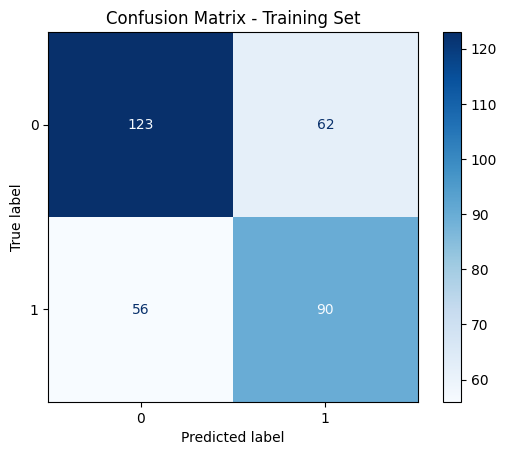

In [226]:
KNeighbors.trainconfusionMatrix()

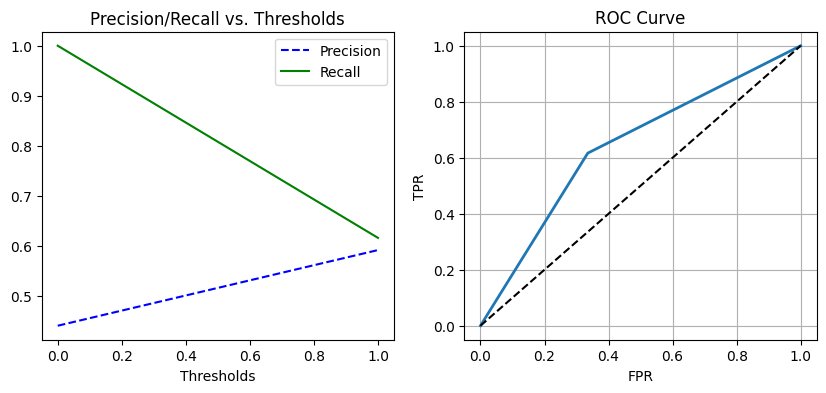

AUC: 0.6406516105146242.


In [232]:
fpr_knn, tpr_knn = KNeighbors.trainPR_ROC()

#### Test Set

In [228]:
KNeighbors.testModel()

Accuracy: 0.7469879518072289.
Precision: 0.7428571428571429.
Recall: 0.6842105263157895.
F1 Score: 0.7123287671232877.


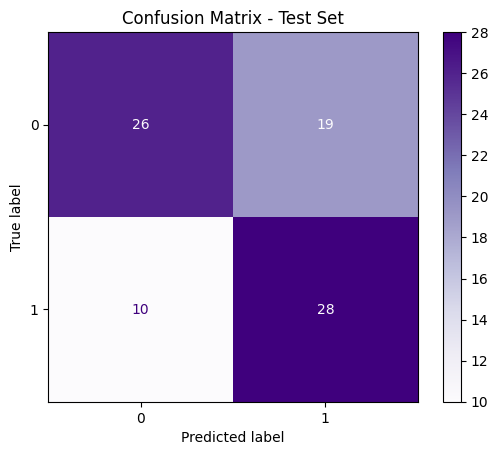

In [229]:
KNeighbors.testconfusionMatrix()

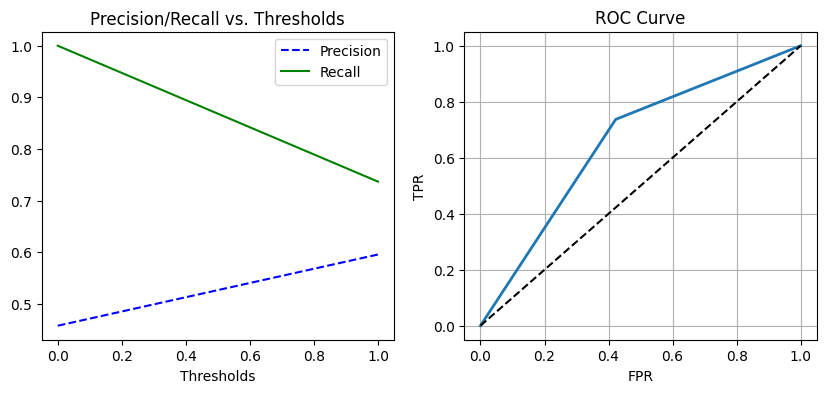

AUC: 0.6573099415204678.


In [233]:
KNeighbors.testPR_ROC()

___

## Predicting Kidney Stone

SGD and AdaBoost were the models with the best numbers, both in accuracy and AUC. We already have instances of those models, so let's just try to predict the test data.

In [260]:
sgd.fit(X, y)

SGDClassifier(alpha=0.01, eta0=0.1, loss='modified_huber', penalty='l1')

In [261]:
pred_sgd = sgd.predict_proba(test_prepared)

In [262]:
ada_.fit(X, y)

AdaBoostClassifier(learning_rate=0.01, n_estimators=150)

In [263]:
pred_ada = ada_.predict_proba(test_prepared)

In [264]:
knn.fit(X, y)

KNeighborsClassifier(n_neighbors=11, weights='distance')

In [265]:
pred_knn = knn.predict_proba(test_prepared)

## Merging Results

### All 3

In [268]:
res = pd.DataFrame({
    "ID":test_ids, 
    "SGD":pred_sgd[:,1],
    "Ada":pred_ada[:,1],
    "KNN":pred_knn[:,1]
})

In [269]:
res.head()

,ID,SGD,Ada,KNN
0,414,0.221516,0.313150,0.000000
1,415,0.276281,0.529535,0.544880
2,416,1.000000,0.650322,0.844377
3,417,0.386261,0.529535,0.576869
4,418,0.216502,0.369373,0.204114


In [276]:
res["Mean"] = res[["SGD", "Ada", "KNN"]].mean(axis=1)

In [277]:
res.head()

,ID,SGD,Ada,KNN,Mean
0,414,0.221516,0.313150,0.000000,0.178222
1,415,0.276281,0.529535,0.544880,0.450232
2,416,1.000000,0.650322,0.844377,0.831566
3,417,0.386261,0.529535,0.576869,0.497555
4,418,0.216502,0.369373,0.204114,0.263330


In [281]:
pd.DataFrame({"id":res["ID"], "cost":res["Mean"]}).to_csv("submissionEnsemble.csv", index=False)

<div style="text-align: center;"><span style="font-size: 24px; font-family: Times New Roman, sans-serif; 
          color: #EEE; background-color: #008CBA">Model Score: 0.85066</span></div>

### SGD and ADA

In [282]:
res = pd.DataFrame({
    "ID":test_ids, 
    "SGD":pred_sgd[:,1],
    "Ada":pred_ada[:,1]
})

In [283]:
res.head()

,ID,SGD,Ada
0,414,0.221516,0.313150
1,415,0.276281,0.529535
2,416,1.000000,0.650322
3,417,0.386261,0.529535
4,418,0.216502,0.369373


In [284]:
res["Mean"] = res[["SGD", "Ada"]].mean(axis=1)

In [285]:
res.head()

,ID,SGD,Ada,Mean
0,414,0.221516,0.313150,0.267333
1,415,0.276281,0.529535,0.402908
2,416,1.000000,0.650322,0.825161
3,417,0.386261,0.529535,0.457898
4,418,0.216502,0.369373,0.292938


In [286]:
pd.DataFrame({"id":res["ID"], "cost":res["Mean"]}).to_csv("submissionEnsemble2.csv", index=False)

<div style="text-align: center;"><span style="font-size: 24px; font-family: Times New Roman, sans-serif; 
          color: #EEE; background-color: #008CBA">Model Score: 0.83733</span></div>